In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "nf": hp.choice('nf', [64, 128, 256]),
    "fc_dropout": hp.choice('fc_dropout', [0.0, 0.1, 0.2, 0.5]),
    "bn": hp.choice('bn', [True, False]),
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x120bbfc1248>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x120bbfc1888>,
 'lr': <hyperopt.pyll.base.Apply at 0x120bbfc1fc8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x120bbfc3608>,
 'patience': <hyperopt.pyll.base.Apply at 0x120bbfc3b88>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x120bbfb41c8>,
 'nf': <hyperopt.pyll.base.Apply at 0x120babab248>,
 'fc_dropout': <hyperopt.pyll.base.Apply at 0x120bbfb4dc8>,
 'bn': <hyperopt.pyll.base.Apply at 0x120babae348>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = XCM
        k = {
            'nf': params['nf'],
            'fc_dropout': params['fc_dropout'],
            'bn': params['bn']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 256, 'bn': False, 'epochs': 100, 'fc_dropout': 0.5, 'lr': 0.001, 'nf': 128, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 5, 'time_steps': 30}
XCM                                                                                                                    
  0%|                                                                           | 0/30 [00:30<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.063906,1.012615,0.656532,00:06
1,0.967934,0.955240,0.664688,00:04
2,0.942046,0.951414,0.669466,00:04
3,0.923804,0.947562,0.666860,00:04
4,0.909622,0.935246,0.674581,00:04
5,0.884345,0.931673,0.676994,00:04
6,0.880244,0.950663,0.674630,00:04
7,0.877865,0.958203,0.670334,00:04
8,0.862087,0.979667,0.678394,00:04
9,0.852458,0.935636,0.680903,00:04


No improvement since epoch 5: early stopping                                                                           
  0%|                                                                           | 0/30 [01:25<?, ?trial/s, best loss=?]

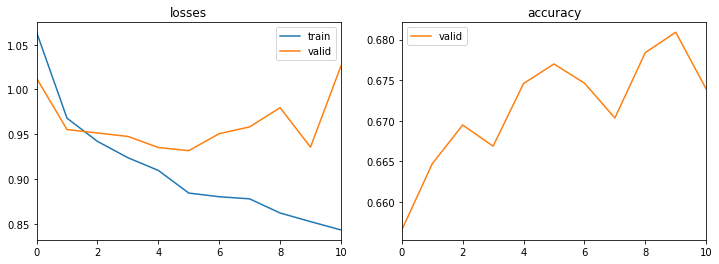

Trying params:                                                                                                         
{'batch_size': 256, 'bn': False, 'epochs': 100, 'fc_dropout': 0.1, 'lr': 0.001, 'nf': 256, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 10, 'time_steps': 30}
XCM                                                                                                                    
  3%|█▋                                               | 1/30 [01:54<41:32, 85.94s/trial, best loss: 1.0261788368225098]

epoch,train_loss,valid_loss,accuracy,time
0,0.977032,0.963449,0.661599,00:08
1,0.937275,0.937119,0.668742,00:07
2,0.912170,0.934551,0.670238,00:07
3,0.896983,0.946452,0.665171,00:07
4,0.878230,0.930098,0.667535,00:07
5,0.868109,0.928036,0.665943,00:07
6,0.868265,1.000711,0.657159,00:07
7,0.840881,1.009479,0.648473,00:07
8,0.830157,0.923916,0.682737,00:07
9,0.814445,1.017118,0.675547,00:07


No improvement since epoch 8: early stopping                                                                           
  3%|█▋                                               | 1/30 [04:26<41:32, 85.94s/trial, best loss: 1.0261788368225098]

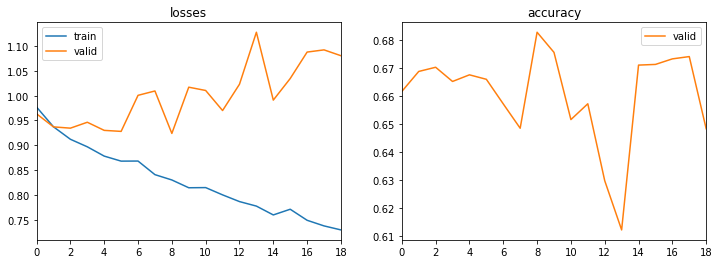

Trying params:                                                                                                         
{'batch_size': 256, 'bn': False, 'epochs': 100, 'fc_dropout': 0.2, 'lr': 0.0001, 'nf': 128, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
  7%|███▏                                            | 2/30 [04:55<53:19, 114.28s/trial, best loss: 1.0261788368225098]

epoch,train_loss,valid_loss,accuracy,time
0,1.478535,1.479917,0.525650,00:09
1,1.308286,1.333069,0.581680,00:07
2,1.183627,1.188794,0.622026,00:07
3,1.070557,1.066353,0.639255,00:08
4,0.989037,0.984516,0.652719,00:08
5,0.935490,0.938313,0.658125,00:08
6,0.911257,0.910288,0.665364,00:08
7,0.881231,0.912136,0.665219,00:08
8,0.866545,0.901918,0.666618,00:08
9,0.840300,0.901466,0.665219,00:08


No improvement since epoch 15: early stopping                                                                          
  7%|███▏                                            | 2/30 [08:26<53:19, 114.28s/trial, best loss: 1.0261788368225098]

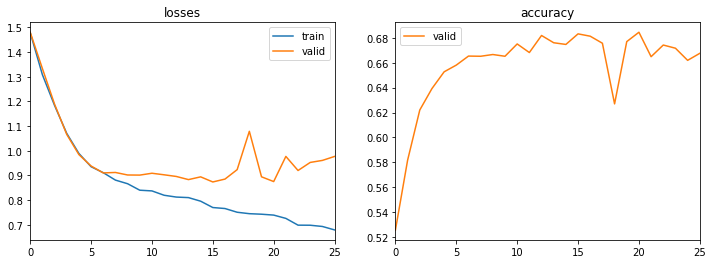

Trying params:                                                                                                         
{'batch_size': 256, 'bn': False, 'epochs': 10, 'fc_dropout': 0.2, 'lr': 0.0001, 'nf': 256, 'optimizer': <function SGD at 0x00000120FBE4A0D8>, 'patience': 5, 'time_steps': 30}
XCM                                                                                                                    
 10%|████▌                                         | 3/30 [08:54<1:08:29, 152.19s/trial, best loss: 0.9769927859306335]

epoch,train_loss,valid_loss,accuracy,time
0,1.644573,1.616460,0.589064,00:07
1,1.444939,1.393493,0.664543,00:07
2,1.284976,1.234072,0.664543,00:07
3,1.221246,1.168895,0.664543,00:07
4,1.188474,1.140881,0.664543,00:07
5,1.164893,1.124847,0.664543,00:07
6,1.156367,1.118137,0.664543,00:07
7,1.154464,1.114000,0.664543,00:07
8,1.148570,1.112141,0.664543,00:07
9,1.153646,1.113745,0.664543,00:07


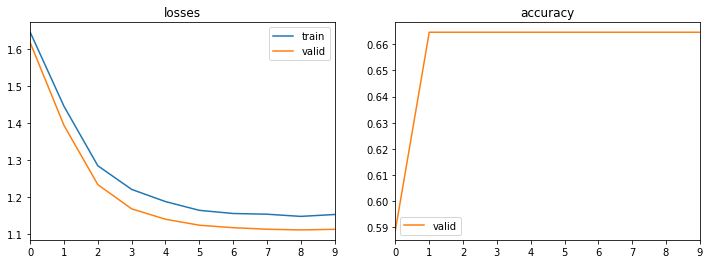

Trying params:                                                                                                         
{'batch_size': 512, 'bn': False, 'epochs': 50, 'fc_dropout': 0.1, 'lr': 0.1, 'nf': 256, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 30}
XCM                                                                                                                    
 13%|██████▏                                       | 4/30 [10:41<1:00:02, 138.54s/trial, best loss: 0.9769927859306335]

epoch,train_loss,valid_loss,accuracy,time
0,0.985977,1.041740,0.653347,00:08
1,0.965440,0.958352,0.658945,00:07
2,0.958662,1.018583,0.640317,00:07
3,0.956836,0.931797,0.661889,00:07
4,0.957799,1.040264,0.650355,00:07
5,0.946740,0.974504,0.667149,00:07
6,0.939197,1.095205,0.665219,00:07
7,0.937164,0.944074,0.663964,00:07
8,0.919058,0.961795,0.665557,00:07
9,0.898374,1.031577,0.668742,00:07


No improvement since epoch 3: early stopping                                                                           
 13%|██████▏                                       | 4/30 [12:26<1:00:02, 138.54s/trial, best loss: 0.9769927859306335]

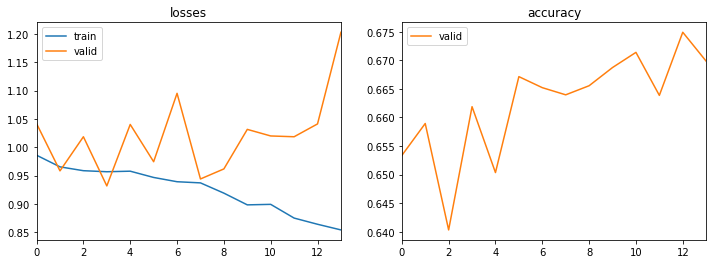

Trying params:                                                                                                         
{'batch_size': 256, 'bn': False, 'epochs': 50, 'fc_dropout': 0.1, 'lr': 0.001, 'nf': 128, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 10, 'time_steps': 30}
XCM                                                                                                                    
 17%|████████                                        | 5/30 [12:54<57:00, 136.82s/trial, best loss: 0.9769927859306335]

epoch,train_loss,valid_loss,accuracy,time
0,1.118512,1.069133,0.644660,00:04
1,0.946645,0.951434,0.664447,00:04
2,0.916759,0.937983,0.670045,00:04
3,0.894767,0.940919,0.675402,00:05
4,0.880984,1.002527,0.649003,00:05
5,0.857595,1.000328,0.653009,00:05
6,0.849203,0.950311,0.677380,00:05
7,0.843937,0.994879,0.666184,00:05
8,0.842414,0.978995,0.675788,00:05
9,0.828043,1.026515,0.668356,00:05


No improvement since epoch 2: early stopping                                                                           
 17%|████████                                        | 5/30 [13:59<57:00, 136.82s/trial, best loss: 0.9769927859306335]

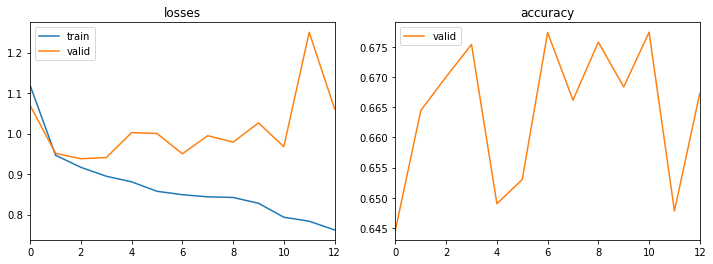

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 10, 'fc_dropout': 0.1, 'lr': 0.1, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 20%|█████████▌                                      | 6/30 [14:28<49:32, 123.87s/trial, best loss: 0.9769927859306335]

epoch,train_loss,valid_loss,accuracy,time
0,0.984978,0.994498,0.665701,00:05
1,1.003105,0.928961,0.676753,00:04
2,0.973341,0.940604,0.666329,00:04
3,0.963501,1.093930,0.665701,00:04
4,0.922239,1.014928,0.673182,00:04
5,0.893149,0.903071,0.680421,00:04
6,0.850025,0.898839,0.674002,00:04
7,0.820335,0.875700,0.683703,00:04
8,0.802162,0.887467,0.681483,00:04
9,0.788157,0.901102,0.679407,00:04


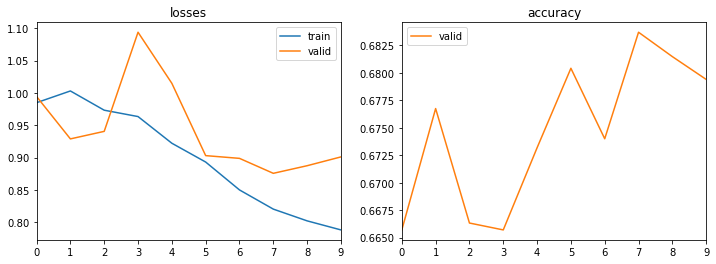

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 10, 'fc_dropout': 0.2, 'lr': 0.0001, 'nf': 64, 'optimizer': <function SGD at 0x00000120FBE4A0D8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 23%|███████████▏                                    | 7/30 [15:42<41:40, 108.73s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.860846,1.838203,0.220260,00:04
1,1.769019,1.750462,0.307418,00:04
2,1.695690,1.702824,0.391004,00:04
3,1.655622,1.678368,0.426427,00:04
4,1.633377,1.654618,0.450364,00:04
5,1.618822,1.651053,0.459148,00:04
6,1.612422,1.652579,0.461609,00:04
7,1.610282,1.642983,0.469379,00:04
8,1.606822,1.640886,0.470344,00:04
9,1.607021,1.646450,0.467786,00:04


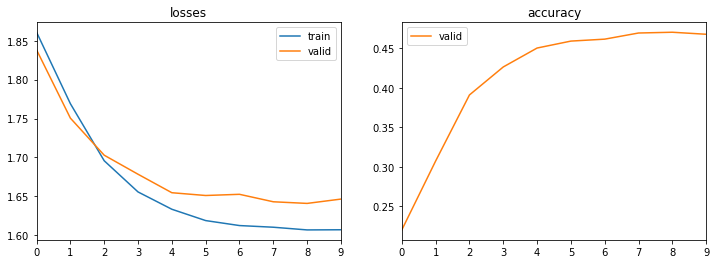

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 100, 'fc_dropout': 0.1, 'lr': 0.1, 'nf': 128, 'optimizer': <function SGD at 0x00000120FBE4A0D8>, 'patience': 5, 'time_steps': 90}
XCM                                                                                                                    
 27%|█████████████                                    | 8/30 [16:55<35:56, 98.02s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.503526,1.576030,0.555716,00:12
1,1.389912,1.410435,0.612229,00:11
2,1.270573,1.174526,0.661358,00:11
3,1.187668,1.074096,0.670334,00:11
4,1.103451,0.991633,0.672796,00:11
5,1.057096,0.964308,0.677380,00:11
6,0.987989,0.990913,0.668501,00:11
7,0.930356,0.920531,0.683654,00:11
8,0.900675,1.134858,0.608272,00:11
9,0.878948,0.891332,0.689445,00:11


No improvement since epoch 14: early stopping                                                                          
 27%|█████████████                                    | 8/30 [20:46<35:56, 98.02s/trial, best loss: 0.9011023044586182]

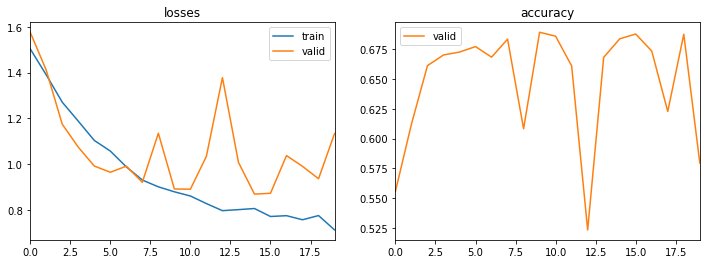

Trying params:                                                                                                         
{'batch_size': 256, 'bn': True, 'epochs': 50, 'fc_dropout': 0.5, 'lr': 0.1, 'nf': 128, 'optimizer': <function SGD at 0x00000120FBE4A0D8>, 'patience': 10, 'time_steps': 90}
XCM                                                                                                                    
 30%|██████████████▍                                 | 9/30 [21:15<51:20, 146.71s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.370813,1.315301,0.631581,00:12
1,1.151096,1.100188,0.675547,00:11
2,1.008132,0.929942,0.682641,00:12
3,0.929787,0.895404,0.678877,00:11
4,0.880242,0.903079,0.682786,00:12
5,0.847019,0.963317,0.649438,00:12
6,0.814232,1.048354,0.666184,00:11
7,0.786004,0.916406,0.677332,00:12
8,0.755512,1.058488,0.666667,00:12
9,0.724779,1.108591,0.645480,00:11


No improvement since epoch 3: early stopping                                                                           
 30%|██████████████▍                                 | 9/30 [24:04<51:20, 146.71s/trial, best loss: 0.9011023044586182]

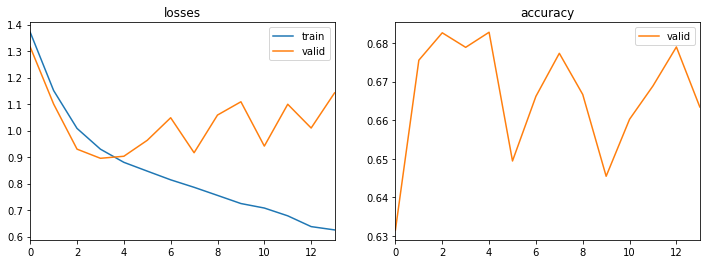

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 100, 'fc_dropout': 0.2, 'lr': 0.1, 'nf': 256, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 5, 'time_steps': 60}
XCM                                                                                                                    
 33%|███████████████▋                               | 10/30 [24:33<54:01, 162.06s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,0.947411,0.876776,0.671927,00:14
1,0.915376,0.951148,0.671155,00:13
2,0.890085,0.973367,0.649679,00:13
3,0.878098,0.998771,0.662082,00:13
4,0.867234,0.930062,0.677332,00:13
5,0.864765,0.928579,0.678635,00:13


No improvement since epoch 0: early stopping                                                                           
 33%|███████████████▋                               | 10/30 [25:57<54:01, 162.06s/trial, best loss: 0.9011023044586182]

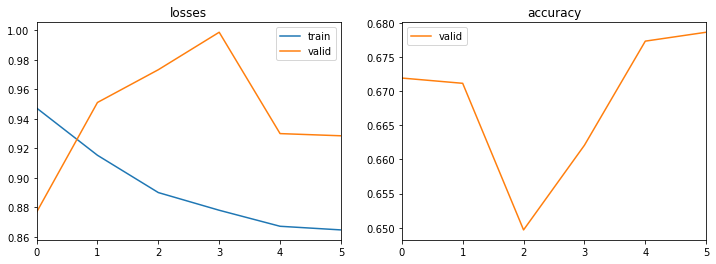

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.5, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 5, 'time_steps': 60}
XCM                                                                                                                    
 37%|█████████████████▏                             | 11/30 [26:26<46:37, 147.22s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.273641,1.437940,0.530911,00:04
1,0.993390,0.923619,0.662130,00:04
2,0.939312,0.888402,0.666667,00:04
3,0.914250,0.905071,0.676174,00:04
4,0.892985,0.872517,0.679649,00:04
5,0.865837,0.883419,0.669804,00:04
6,0.835666,0.943816,0.669031,00:04
7,0.801111,0.899399,0.679456,00:04
8,0.782358,0.908267,0.680131,00:04
9,0.771844,0.910919,0.680469,00:04


No improvement since epoch 4: early stopping                                                                           
 37%|█████████████████▏                             | 11/30 [27:08<46:37, 147.22s/trial, best loss: 0.9011023044586182]

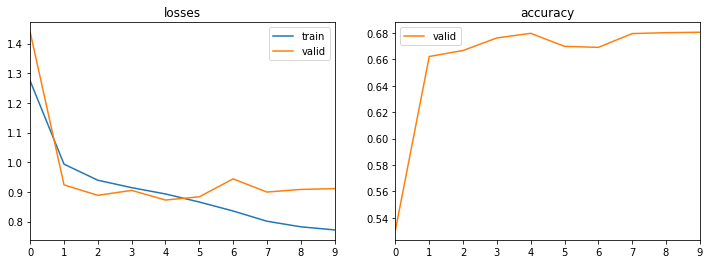

Trying params:                                                                                                         
{'batch_size': 256, 'bn': True, 'epochs': 10, 'fc_dropout': 0.1, 'lr': 0.1, 'nf': 128, 'optimizer': <function SGD at 0x00000120FBE4A0D8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 40%|██████████████████▊                            | 12/30 [27:38<37:20, 124.48s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.134195,1.127975,0.601226,00:08
1,0.924861,0.956482,0.675595,00:08
2,0.848914,0.991887,0.644708,00:08
3,0.796559,0.928663,0.669514,00:08
4,0.759844,0.956803,0.670141,00:08
5,0.710538,0.980686,0.657546,00:08
6,0.664915,1.089919,0.659283,00:08
7,0.606396,1.113358,0.671010,00:08
8,0.576235,1.071442,0.657594,00:08
9,0.559772,1.068890,0.663675,00:08


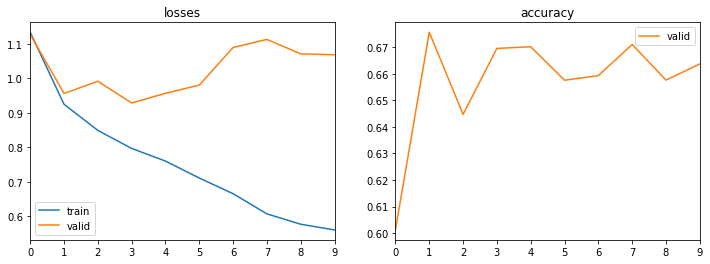

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 100, 'fc_dropout': 0.5, 'lr': 0.001, 'nf': 128, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 5, 'time_steps': 30}
XCM                                                                                                                    
 43%|████████████████████▎                          | 13/30 [29:28<34:06, 120.38s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.580197,1.517272,0.580184,00:04
1,1.424209,1.388219,0.632016,00:04
2,1.335494,1.268172,0.653347,00:04
3,1.232697,1.255475,0.649293,00:04
4,1.147158,1.110824,0.668838,00:04
5,1.072549,1.107611,0.658366,00:04
6,1.015779,1.050557,0.671734,00:04
7,0.965994,1.044382,0.655470,00:04
8,0.904740,1.015097,0.665364,00:04
9,0.879686,1.033241,0.648183,00:04


No improvement since epoch 8: early stopping                                                                           
 43%|████████████████████▎                          | 13/30 [30:30<34:06, 120.38s/trial, best loss: 0.9011023044586182]

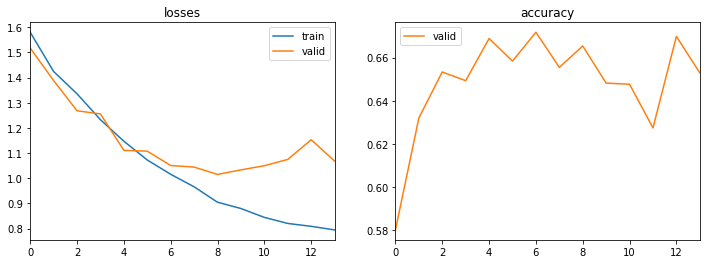

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 10, 'fc_dropout': 0.5, 'lr': 0.1, 'nf': 128, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 5, 'time_steps': 90}
XCM                                                                                                                    
 47%|█████████████████████▉                         | 14/30 [30:59<29:46, 111.66s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,0.918513,0.858048,0.674340,00:11
1,0.858417,0.954958,0.672989,00:11
2,0.832009,1.081685,0.668018,00:11
3,0.801135,1.072770,0.661020,00:11
4,0.749674,1.012206,0.637904,00:11
5,0.709291,1.016158,0.641185,00:11


No improvement since epoch 0: early stopping                                                                           
 47%|█████████████████████▉                         | 14/30 [32:08<29:46, 111.66s/trial, best loss: 0.9011023044586182]

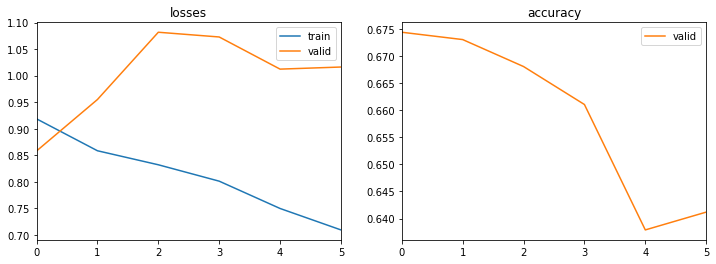

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': False, 'epochs': 100, 'fc_dropout': 0.5, 'lr': 0.1, 'nf': 128, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 5, 'time_steps': 60}
XCM                                                                                                                    
 50%|███████████████████████▌                       | 15/30 [32:37<26:52, 107.51s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,0.969591,0.903261,0.661213,00:07
1,0.910214,0.888455,0.674967,00:07
2,0.881706,0.887718,0.664881,00:07
3,0.868235,0.899012,0.671300,00:07
4,0.840646,0.870604,0.686743,00:07
5,0.820059,0.868410,0.690121,00:07
6,0.790035,0.896216,0.671058,00:07
7,0.772352,0.967642,0.677622,00:07
8,0.758821,0.988401,0.682737,00:07
9,0.735812,0.965992,0.653829,00:07


No improvement since epoch 5: early stopping                                                                           
 50%|███████████████████████▌                       | 15/30 [33:58<26:52, 107.51s/trial, best loss: 0.9011023044586182]

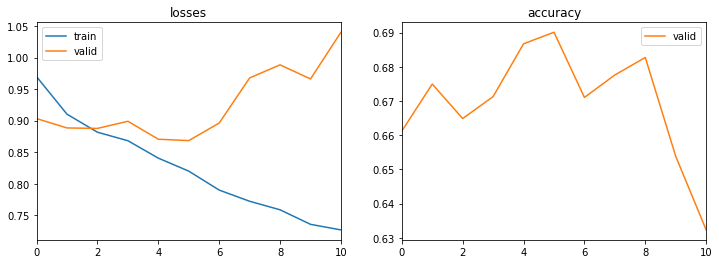

Trying params:                                                                                                         
{'batch_size': 256, 'bn': False, 'epochs': 100, 'fc_dropout': 0.2, 'lr': 0.001, 'nf': 256, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 5, 'time_steps': 90}
XCM                                                                                                                    
 53%|█████████████████████████                      | 16/30 [34:28<25:16, 108.34s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,0.926286,0.889851,0.674002,00:21
1,0.841635,0.837729,0.689735,00:21
2,0.788701,0.855436,0.681434,00:21
3,0.763697,0.812708,0.700497,00:21
4,0.714552,0.776764,0.699387,00:21
5,0.682808,0.944348,0.653636,00:21
6,0.648255,0.842709,0.684909,00:21
7,0.645281,1.089488,0.646446,00:21
8,0.617924,1.175032,0.636890,00:21
9,0.607924,1.103711,0.661213,00:21


No improvement since epoch 4: early stopping                                                                           
 53%|█████████████████████████                      | 16/30 [38:01<25:16, 108.34s/trial, best loss: 0.9011023044586182]

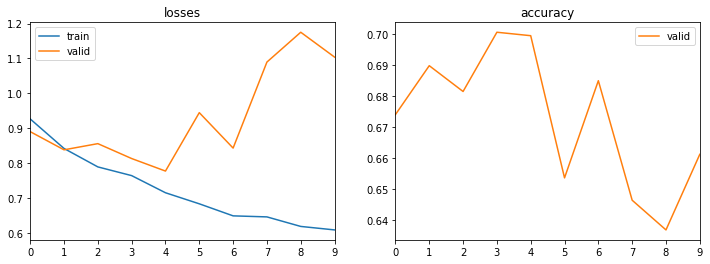

Trying params:                                                                                                         
{'batch_size': 512, 'bn': False, 'epochs': 100, 'fc_dropout': 0.1, 'lr': 0.1, 'nf': 256, 'optimizer': <function Adam at 0x00000120FBE4A438>, 'patience': 5, 'time_steps': 90}
XCM                                                                                                                    
 57%|██████████████████████████▋                    | 17/30 [38:30<32:11, 148.57s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,0.885120,0.845603,0.682979,00:21
1,0.832029,0.835681,0.673954,00:20
2,0.809551,0.810769,0.691038,00:20
3,0.796210,0.929540,0.676898,00:20
4,0.779402,0.933880,0.657352,00:20
5,0.730197,1.008173,0.669852,00:20
6,0.711643,0.952271,0.604701,00:20
7,0.680364,1.040332,0.668549,00:20


No improvement since epoch 2: early stopping                                                                           
 57%|██████████████████████████▋                    | 17/30 [41:17<32:11, 148.57s/trial, best loss: 0.9011023044586182]

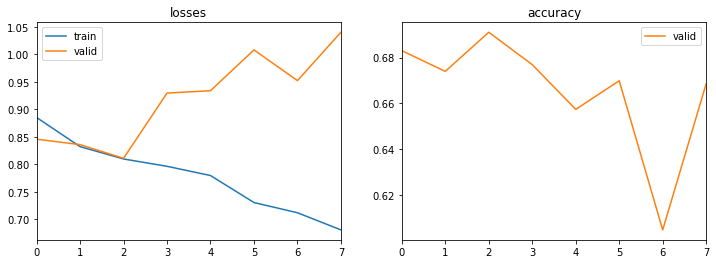

Trying params:                                                                                                         
{'batch_size': 256, 'bn': True, 'epochs': 10, 'fc_dropout': 0.5, 'lr': 0.0001, 'nf': 256, 'optimizer': <function SGD at 0x00000120FBE4A0D8>, 'patience': 5, 'time_steps': 90}
XCM                                                                                                                    
 60%|████████████████████████████▏                  | 18/30 [41:46<32:34, 162.85s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.974363,1.849357,0.236861,00:20
1,1.848798,1.817033,0.451860,00:21
2,1.783248,1.787324,0.497032,00:21
3,1.759343,1.808621,0.492399,00:21
4,1.733401,1.793229,0.493557,00:21
5,1.706755,1.716375,0.511558,00:21
6,1.695381,1.722144,0.497273,00:21
7,1.683932,1.688946,0.503595,00:21
8,1.671056,1.679056,0.506395,00:21
9,1.678981,1.689374,0.502920,00:21


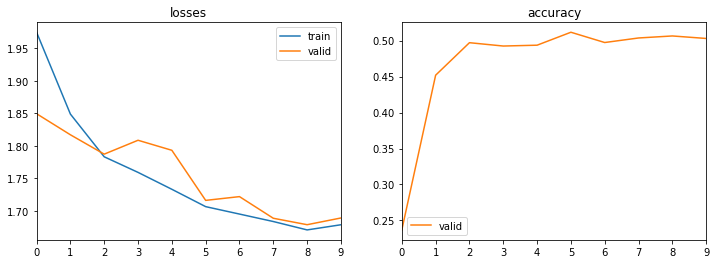

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.2, 'lr': 0.0001, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 30}
XCM                                                                                                                    
 63%|█████████████████████████████▊                 | 19/30 [45:46<34:08, 186.21s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.729787,1.667220,0.485884,00:03
1,1.594906,1.571127,0.556633,00:02
2,1.516282,1.522193,0.551663,00:02
3,1.454000,1.452510,0.593408,00:02
4,1.394837,1.376228,0.618744,00:02
5,1.357028,1.387374,0.614739,00:02
6,1.325369,1.350965,0.619806,00:02
7,1.311594,1.329937,0.623377,00:02
8,1.297467,1.324858,0.623667,00:02
9,1.294782,1.331110,0.623474,00:02


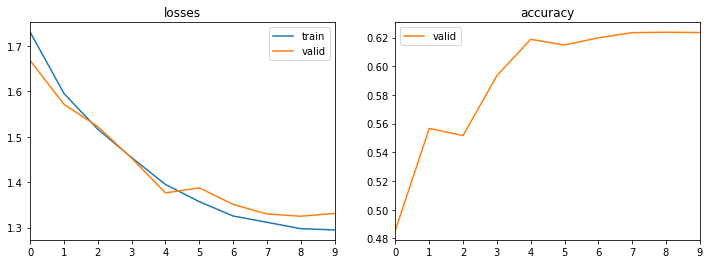

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 67%|███████████████████████████████▎               | 20/30 [46:41<24:25, 146.54s/trial, best loss: 0.9011023044586182]

epoch,train_loss,valid_loss,accuracy,time
0,1.161677,1.013707,0.639882,00:04
1,0.984549,0.957819,0.662613,00:04
2,0.953165,0.985349,0.663385,00:04
3,0.925544,0.884457,0.673085,00:04
4,0.904749,0.934677,0.675160,00:04
5,0.877097,0.944955,0.659331,00:04
6,0.844594,0.875119,0.674774,00:04
7,0.802437,0.868041,0.675160,00:04
8,0.772776,0.878758,0.684282,00:04
9,0.757902,0.883794,0.680131,00:04


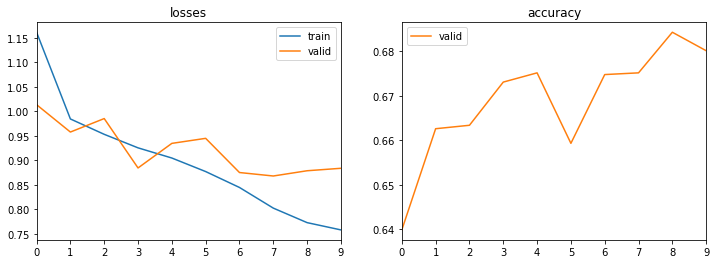

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 70%|████████████████████████████████▉              | 21/30 [47:51<18:33, 123.72s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.169875,0.967389,0.650886,00:04
1,0.973526,1.222134,0.614594,00:04
2,0.924806,0.920919,0.675981,00:04
3,0.893463,0.969908,0.660972,00:04
4,0.872496,0.940765,0.671541,00:04
5,0.840133,0.943457,0.673375,00:04
6,0.801760,0.876999,0.675450,00:04
7,0.764439,0.910865,0.672989,00:04
8,0.734113,0.949226,0.673278,00:04
9,0.719367,0.951503,0.672603,00:04


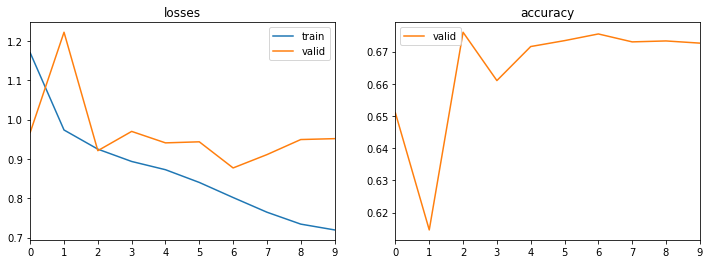

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 73%|██████████████████████████████████▍            | 22/30 [49:01<14:20, 107.59s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.180339,0.953382,0.668114,00:04
1,0.970274,0.953472,0.661213,00:04
2,0.924836,1.014411,0.622364,00:04
3,0.886330,0.977210,0.648328,00:04
4,0.852079,0.883024,0.676753,00:04
5,0.818715,0.870064,0.682834,00:04
6,0.780937,0.934965,0.677477,00:04
7,0.740462,0.903147,0.677043,00:04
8,0.712549,0.914511,0.674244,00:04
9,0.698793,0.916553,0.675305,00:04


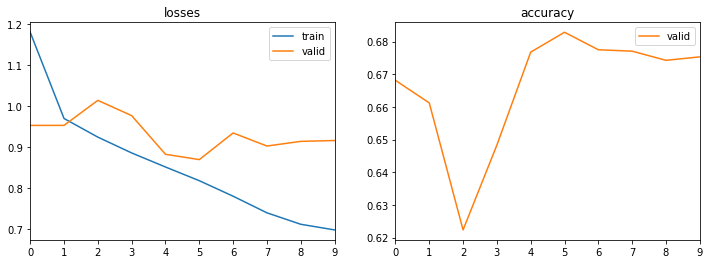

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 77%|████████████████████████████████████▊           | 23/30 [50:11<11:13, 96.28s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,0.985308,0.898988,0.680035,00:04
1,0.916560,0.913389,0.671396,00:04
2,0.880305,1.018846,0.646590,00:04
3,0.829602,0.884165,0.682930,00:04
4,0.777294,0.946797,0.673520,00:04
5,0.737046,0.936991,0.686116,00:04
6,0.681903,0.973105,0.669659,00:04
7,0.650016,1.097512,0.681386,00:04
8,0.623727,1.065569,0.670817,00:04
9,0.611961,1.058571,0.670190,00:04


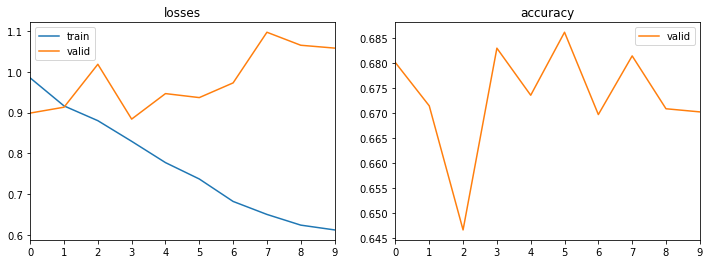

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 80%|██████████████████████████████████████▍         | 24/30 [51:24<08:55, 89.21s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.177570,0.917948,0.668018,00:04
1,0.971960,1.114271,0.637614,00:04
2,0.922358,0.906538,0.673954,00:04
3,0.894053,0.972535,0.671589,00:04
4,0.864811,0.892045,0.678732,00:04
5,0.835273,0.918256,0.676463,00:04
6,0.793654,0.913735,0.669852,00:04
7,0.753003,0.947418,0.679552,00:04
8,0.727321,0.948550,0.671879,00:04
9,0.713949,0.947056,0.675643,00:04


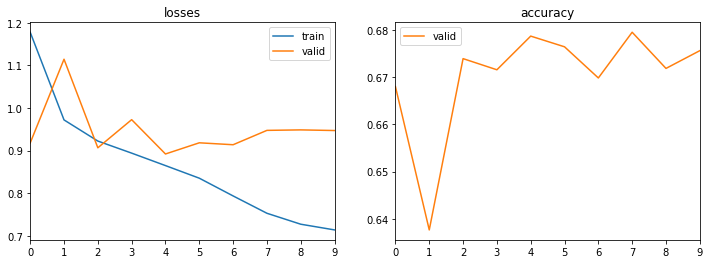

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 50, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 83%|████████████████████████████████████████        | 25/30 [52:34<06:57, 83.51s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.122762,1.021918,0.641716,00:04
1,0.909456,0.935648,0.674533,00:04
2,0.885279,0.904685,0.675836,00:04
3,0.870835,0.987610,0.670190,00:04
4,0.858011,1.061237,0.667632,00:04
5,0.842544,0.938795,0.651899,00:04
6,0.819503,0.956258,0.680373,00:04
7,0.793541,1.274256,0.595386,00:04
8,0.770308,1.386447,0.627721,00:04
9,0.742676,1.019663,0.654988,00:04


No improvement since epoch 2: early stopping                                                                           
 83%|████████████████████████████████████████        | 25/30 [53:31<06:57, 83.51s/trial, best loss: 0.8837941884994507]

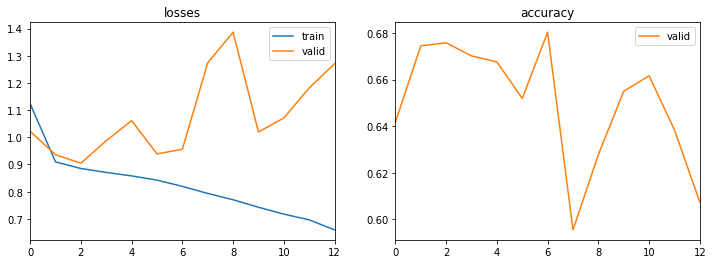

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 87%|█████████████████████████████████████████▌      | 26/30 [54:00<05:37, 84.30s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.182223,0.982990,0.674195,00:04
1,0.988467,0.964273,0.664591,00:04
2,0.922812,0.944933,0.670817,00:04
3,0.880863,2.758490,0.465808,00:04
4,0.849980,0.975805,0.654891,00:04
5,0.813811,1.006207,0.666377,00:04
6,0.762066,0.954785,0.678442,00:04
7,0.719473,0.960846,0.662806,00:04
8,0.685839,0.965412,0.673664,00:04
9,0.668404,0.974777,0.671010,00:04


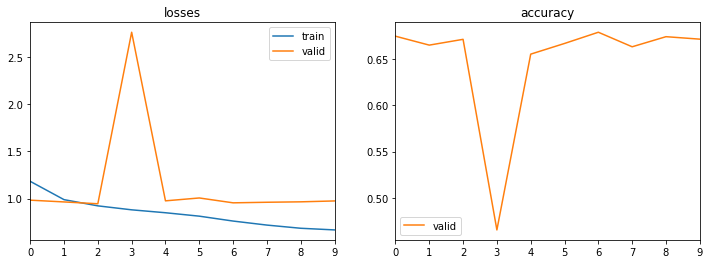

Trying params:                                                                                                         
{'batch_size': 512, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 90%|███████████████████████████████████████████▏    | 27/30 [55:11<04:00, 80.02s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,0.994790,1.023795,0.610540,00:04
1,0.925947,0.942035,0.674726,00:04
2,0.891101,0.920016,0.676367,00:04
3,0.844699,0.893188,0.679504,00:04
4,0.802746,1.060687,0.636359,00:04
5,0.758954,0.917149,0.681627,00:04
6,0.710693,1.071296,0.649679,00:04
7,0.673609,1.027833,0.674871,00:04
8,0.654015,1.042110,0.663530,00:04
9,0.638590,1.038371,0.664688,00:04


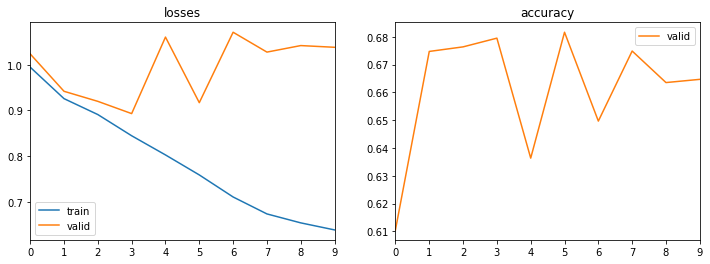

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.1, 'lr': 0.1, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 93%|████████████████████████████████████████████▊   | 28/30 [56:24<02:36, 78.15s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.015456,1.387852,0.493123,00:04
1,1.093916,0.969717,0.651996,00:04
2,0.987973,0.971036,0.649341,00:04
3,1.181678,1.075064,0.667584,00:04
4,0.971003,0.892273,0.667487,00:04
5,0.934123,0.916126,0.665122,00:04
6,0.896067,0.864192,0.674967,00:04
7,0.863498,0.924717,0.661213,00:04
8,0.830692,0.898842,0.675064,00:04
9,0.819652,0.897378,0.675595,00:04


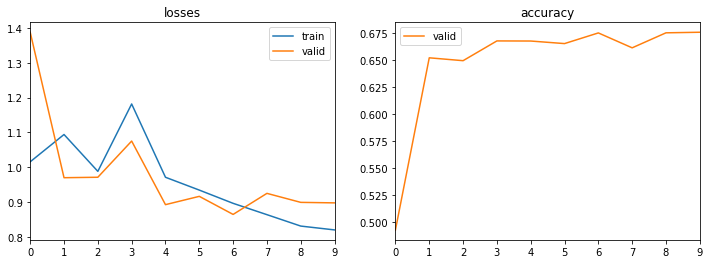

Trying params:                                                                                                         
{'batch_size': 1024, 'bn': True, 'epochs': 50, 'fc_dropout': 0.1, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM                                                                                                                    
 97%|██████████████████████████████████████████████▍ | 29/30 [57:34<01:15, 75.74s/trial, best loss: 0.8837941884994507]

epoch,train_loss,valid_loss,accuracy,time
0,1.288624,1.148469,0.666377,00:04
1,1.086147,1.368712,0.541480,00:04
2,0.950941,1.322011,0.668404,00:04
3,0.915040,0.911320,0.672940,00:04
4,0.908341,0.935914,0.681048,00:04
5,0.877673,1.025048,0.647218,00:04
6,0.859413,1.100771,0.627335,00:04
7,0.842665,0.886924,0.692631,00:04
8,0.814559,1.042988,0.638917,00:04
9,0.781614,0.972371,0.675209,00:04


No improvement since epoch 7: early stopping                                                                           
 97%|██████████████████████████████████████████████▍ | 29/30 [58:48<01:15, 75.74s/trial, best loss: 0.8837941884994507]

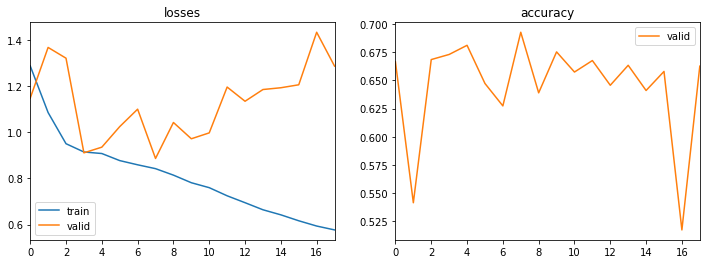

100%|███████████████████████████████████████████████| 30/30 [58:48<00:00, 117.62s/trial, best loss: 0.8837941884994507]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bn': 0, 'bs': 2, 'epochs': 0, 'fc_dropout': 0, 'lr': 1, 'nf': 0, 'optimizer': 2, 'patience': 1, 'ts': 1}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = XCM
    k = {
        'nf': params['nf'],
        'fc_dropout': params['fc_dropout'],
        'bn': params['bn']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 1024, 'bn': True, 'epochs': 10, 'fc_dropout': 0.0, 'lr': 0.01, 'nf': 64, 'optimizer': <function RMSProp at 0x00000120FBE4A1F8>, 'patience': 10, 'time_steps': 60}
XCM


epoch,train_loss,valid_loss,accuracy,time
0,1.160835,1.037707,0.648086,00:04
1,0.964077,0.947426,0.651996,00:04
2,0.920892,0.932850,0.674630,00:04
3,0.887240,2.804080,0.461126,00:04
4,0.859020,0.931274,0.681096,00:04
5,0.826818,0.892770,0.685295,00:04
6,0.788761,0.935527,0.681483,00:04
7,0.754970,0.925616,0.683316,00:04
8,0.726303,0.969447,0.674533,00:04
9,0.715297,0.943497,0.677960,00:04


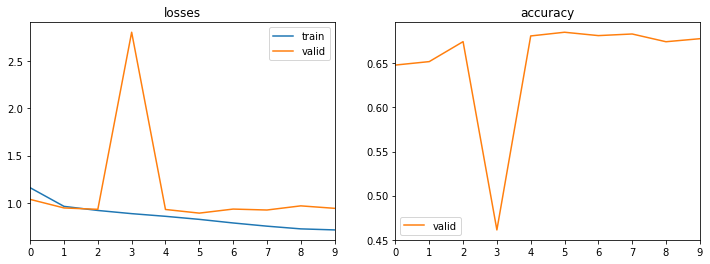

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[1.0412e-01, 5.2371e-01, 2.9686e-01, 7.1882e-02, 3.3698e-03, 5.5525e-05],
         [7.3274e-01, 1.6242e-01, 9.1477e-02, 8.0607e-03, 4.0829e-03, 1.2144e-03],
         [9.6863e-01, 2.8280e-02, 2.7429e-03, 3.3480e-04, 1.1842e-05, 1.0849e-07],
         ...,
         [9.8343e-01, 1.3161e-02, 2.5465e-03, 5.8297e-04, 2.4764e-04, 3.5994e-05],
         [9.9798e-01, 2.0080e-03, 1.5445e-05, 3.6033e-07, 1.9321e-08, 2.1025e-09],
         [9.3753e-01, 5.6773e-02, 5.1244e-03, 5.4220e-04, 3.4111e-05, 6.7888e-07]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([1, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.710153
f1 score:   0.691060


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_XCM', y_test_true)
np.save('y_pred_XCM', y_test_pred)